In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
from models_package.models import Teacher, Student
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# new libraries
from data.data_loader import load_cifar10, load_cifar100, load_imagenet, load_prof
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck
from torchvision.models.resnet import ResNet18_Weights, ResNet34_Weights
from utils.loss_functions import tkd_kdloss

In [2]:
def compare_model_size(teacher, student):
    teacher_params = sum(p.numel() for p in teacher.parameters())
    student_params = sum(p.numel() for p in student.parameters())
    return teacher_params, student_params

def compare_inference_time(teacher, student, dataloader):
    inputs, _ = next(iter(dataloader))
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    teacher = teacher.to(device)
    student = student.to(device)
    inputs = inputs.to(device)
    
    start_time = time.time()
    with torch.no_grad():
        teacher_outputs = teacher(inputs)
    teacher_time = time.time() - start_time

    start_time = time.time()
    with torch.no_grad():
        student_outputs = student(inputs)
    student_time = time.time() - start_time
    
    return teacher_time, student_time

def compare_performance_metrics(teacher, student, dataloader):
    teacher.eval()
    student.eval()
    
    all_labels = []
    all_teacher_preds = []
    all_student_preds = []

    for inputs, labels in dataloader:
        with torch.no_grad():
            teacher_outputs = teacher(inputs.to(device))
            student_outputs = student(inputs.to(device))
        all_labels.append(labels.cpu().numpy())
        all_teacher_preds.append(torch.argmax(teacher_outputs, dim=1).cpu().numpy())
        all_student_preds.append(torch.argmax(student_outputs, dim=1).cpu().numpy())

    all_labels = np.concatenate(all_labels)
    all_teacher_preds = np.concatenate(all_teacher_preds)
    all_student_preds = np.concatenate(all_student_preds)
    
    metrics = {
        'accuracy': (accuracy_score(all_labels, all_teacher_preds), accuracy_score(all_labels, all_student_preds)),
        'precision': (precision_score(all_labels, all_teacher_preds, average='weighted', zero_division=0), precision_score(all_labels, all_student_preds, average='weighted', zero_division=0)),  # Updated line
        'recall': (recall_score(all_labels, all_teacher_preds, average='weighted'), recall_score(all_labels, all_student_preds, average='weighted')),
        'f1': (f1_score(all_labels, all_teacher_preds, average='weighted'), f1_score(all_labels, all_student_preds, average='weighted'))
    }

    return metrics

def plot_comparison(labels, teacher_values, student_values, title, ylabel):
    # Convert parameter count to millions
    if 'Parameter Count' in title or 'Parameter Count' in ylabel:
        teacher_values = [value / 1e6 for value in teacher_values]
        student_values = [value / 1e6 for value in student_values]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, teacher_values, width, label='Teacher')
    rects2 = ax.bar(x + width/2, student_values, width, label='Student')

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()

    plt.show()

In [20]:
# Hyperparameters
learning_rate = 0.001
num_epochs = 2
num_workers = 2
batch_size = 32
temperature = 4.0
alpha = 0.9
momentum = 0.9
num_classes = 10
step_size = 30
gamma = 0.1

# new parameters
# lr_input = 0.1
# momentum_input = 0.9
weight_decay_input = 5e-4
# epochs = 20
# T = 4.0 # temperatureture
# alpha = 0.9
patience = 5  # for early stopping

train_dir = '/home/ubuntu/capstone/W210-Capstone/notebooks/idenprof/train'
test_dir = '/home/ubuntu/capstone/W210-Capstone/notebooks/idenprof/test'

In [21]:
# Load CIFAR-100 dataset
trainloader, testloader = load_prof(train_dir, test_dir)

In [22]:
# Instantiate the models
###################### Testing 1 ######################
# Create instances of your models
teacher_model = torchvision.models.resnet34(weights=ResNet34_Weights.IMAGENET1K_V1).cuda()
teacher_model.eval()  # Set teacher model to evaluation mode
student_model = torchvision.models.resnet18(weights=None).cuda()

In [23]:
# Optimizer and scheduler for the student model
optimizer = optim.SGD(student_model.parameters(), lr=learning_rate, momentum=momentum)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=learning_rate, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

criterion = nn.CrossEntropyLoss()

# # Knowledge Distillation loss function
# def knowledge_distillation_loss(student_outputs, teacher_outputs, temperature):
#     kd_loss = F.kl_div(
#         F.log_softmax(student_outputs / temperature, dim=1),
#         F.softmax(teacher_outputs / temperature, dim=1),
#         reduction='batchmean'
#     ) * (temperature * temperature)
#     return kd_loss

# Function to train the teacher model
def train_teacher(model, trainloader, criterion, optimizer, scheduler, device, num_epochs=5):
    model.train()
    model.to(device)
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(tqdm(trainloader)):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 100 == 99:  # Print every 100 mini-batches
                print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
                running_loss = 0.0
        scheduler.step()
    print("Finished Training Teacher")

# Function to train the student model with knowledge distillation
def train_student_with_distillation(student, teacher, trainloader, criterion, optimizer, scheduler, device, alpha, temperature, num_epochs):
    student.train()
    teacher.eval()
    student.to(device)
    teacher.to(device)
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(tqdm(trainloader)):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            student_outputs = student(inputs)
            with torch.no_grad():
                teacher_outputs = teacher(inputs)
            ce_loss = criterion(student_outputs, labels)
            # kd_loss = knowledge_distillation_loss(student_outputs, teacher_outputs, temperature)
            kd_loss =  tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature) # from utils.loss_functions
            loss = alpha * kd_loss + (1 - alpha) * ce_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 100 == 99:
                print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
                running_loss = 0.0
        scheduler.step()
    print("Finished Training Student")

# Assuming the device is a CUDA device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Call the function to train the teacher model
train_teacher(teacher_model, trainloader, criterion, teacher_optimizer, teacher_scheduler, device, num_epochs=num_epochs)

# Call the function to train the student model with knowledge distillation
train_student_with_distillation(student_model, teacher_model, trainloader, criterion, optimizer, scheduler, device, alpha, temperature, num_epochs=num_epochs)


 36%|██████████████▋                          | 101/282 [00:16<00:29,  6.09it/s]

[1, 100] loss: 1.925


 71%|█████████████████████████████▏           | 201/282 [00:33<00:13,  6.02it/s]

[1, 200] loss: 0.505


 36%|██████████████▋                          | 101/282 [00:17<00:30,  5.98it/s]

[2, 100] loss: 0.157


 71%|█████████████████████████████▏           | 201/282 [00:33<00:13,  5.96it/s]

[2, 200] loss: 0.115


100%|█████████████████████████████████████████| 282/282 [00:47<00:00,  5.93it/s]


Finished Training Teacher


 36%|██████████████▋                          | 101/282 [00:16<00:28,  6.36it/s]

[1, 100] loss: 0.932


 71%|█████████████████████████████▏           | 201/282 [00:31<00:12,  6.38it/s]

[1, 200] loss: 0.595


 36%|██████████████▋                          | 101/282 [00:16<00:28,  6.28it/s]

[2, 100] loss: 0.451


 71%|█████████████████████████████▏           | 201/282 [00:32<00:12,  6.24it/s]

[2, 200] loss: 0.413


100%|█████████████████████████████████████████| 282/282 [00:45<00:00,  6.23it/s]

Finished Training Student


In [16]:
###################### Testing 1 ######################
# Save the student model weights and architecture
torch.save(student_model.state_dict(), 'student_model_weights_ckd_5.pth')
torch.save(student_model, 'student_model_ckd_5.pth')
print('weights and architecture saved and exported')

weights and architecture saved and exported


In [13]:
student_model

Student(
  (layer1): Linear(in_features=3072, out_features=800, bias=True)
  (layer2): Linear(in_features=800, out_features=800, bias=True)
  (layer3): Linear(in_features=800, out_features=100, bias=True)
  (dropout_20): Dropout(p=0.2, inplace=False)
  (dropout_50): Dropout(p=0.5, inplace=False)
)

In [52]:
###################### Testing 1 ######################
# Save the student model weights and architecture
torch.save(teacher_model.state_dict(), 'teacher_model_weights_ckd_1.pth')
torch.save(teacher_model, 'teacher_model_ckd_1.pth')
print('weights and architecture saved and exported')

weights and architecture saved and exported


In [41]:
###################### Testing 2 ######################
# Save the student model weights and architecture
torch.save(student_model.state_dict(), 'student_model_weights_ckd_2.pth')
torch.save(student_model, 'student_model_ckd_2.pth')
print('weights and architecture saved and exported')

weights and architecture saved and exported


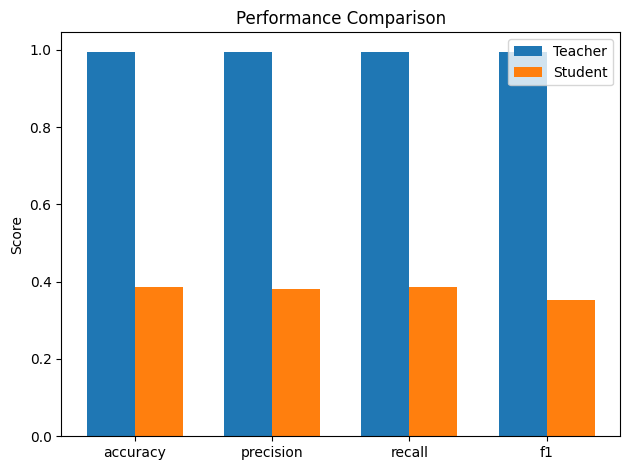

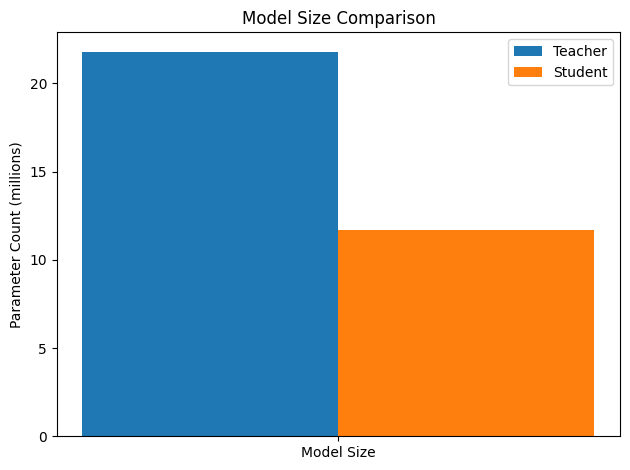

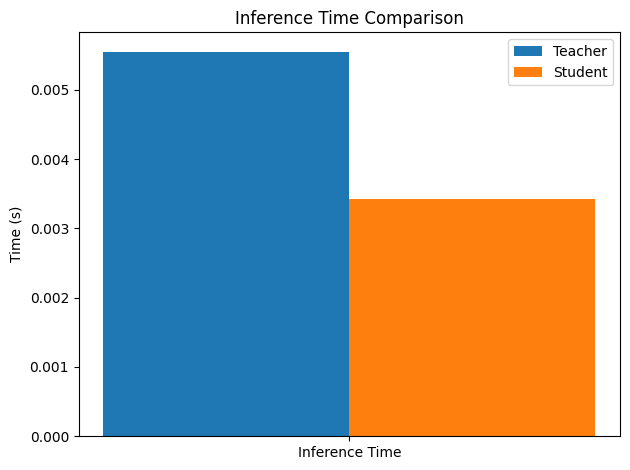

In [24]:
# Call the comparison and plotting functions after training
teacher_params, student_params = compare_model_size(teacher_model, student_model)
teacher_time, student_time = compare_inference_time(teacher_model, student_model, trainloader)
performance_metrics = compare_performance_metrics(teacher_model, student_model, trainloader)

# Extracting the metric values for plotting
performance_labels = ['accuracy', 'precision', 'recall', 'f1']
teacher_performance_values = [performance_metrics[metric][0] for metric in performance_labels]
student_performance_values = [performance_metrics[metric][1] for metric in performance_labels]

# Plotting the comparison for performance metrics
plot_comparison(performance_labels, teacher_performance_values, student_performance_values, 'Performance Comparison', 'Score')

# Plotting the comparison for model size
model_size_labels = ['Model Size']
teacher_model_size_values = [teacher_params]
student_model_size_values = [student_params]
plot_comparison(model_size_labels, teacher_model_size_values, student_model_size_values, 'Model Size Comparison', 'Parameter Count (millions)')

# Plotting the comparison for inference time
inference_time_labels = ['Inference Time']
teacher_inference_time_values = [teacher_time]
student_inference_time_values = [student_time]
plot_comparison(inference_time_labels, teacher_inference_time_values, student_inference_time_values, 'Inference Time Comparison', 'Time (s)')

In [25]:
teacher_performance_values

[0.9951111111111111,
 0.9951508668870811,
 0.9951111111111111,
 0.9951080110330531]

In [26]:
student_performance_values

[0.3851111111111111,
 0.38162559870790774,
 0.3851111111111111,
 0.351330903805517]